# Conformal Prediction for Regression

Conformal Prediction is a machine learning framework that allows to quantify prediction uncertainty to produce reliable probabilisic predictions. Conformal Prediction can be used on top of any underlying classification or regression model and works with any data distribution and any dataset size.

The goal of this notebook is to help you dive deeper into Conformal Prediction for regression problem. We will be working with Inductive Conformal Prediction, Conformalized Quantile Regression and several models from some of the most Conformal Prediction packages including MAPIE, Amazon Fortuna and Crepes.

In [1]:
!pip install dtype_diet
!pip install openml
#!pip install mapie
#!pip install crepes
#!pip install aws-fortuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openml

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import plotly.express as px

from yellowbrick.regressor import PredictionError

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
# List of datasets from openml https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [4]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


In [5]:
# output information about selected dataset - California housing
datasets_df.loc[43939]

name                                  california_housing
version                                                1
uploader                                           30861
status                                            active
format                                              ARFF
MajorityClassSize                                    NaN
MaxNominalAttDistinctValues                          NaN
MinorityClassSize                                    NaN
NumberOfClasses                                      0.0
NumberOfFeatures                                    10.0
NumberOfInstances                                20640.0
NumberOfInstancesWithMissingValues                 207.0
NumberOfMissingValues                              207.0
NumberOfNumericFeatures                              9.0
NumberOfSymbolicFeatures                             1.0
Name: 43939, dtype: object

In [6]:
# California housing dataset https://www.openml.org/search?type=data&status=active&id=43939
dataset = openml.datasets.get_dataset(43939)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'california_housing', the target feature is 'median_house_value'
URL: https://api.openml.org/data/v1/download/22102987/california_housing.arff
Median house prices for California districts derived from the 1990 census.


In [7]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [8]:
categorical_indicator

[False, False, False, False, False, False, False, False, True]

In [9]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,342200.0


In [10]:
df['ocean_proximity'].unique()

array([3., 0., 1., 4., 2.], dtype=float32)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   ocean_proximity     20640 non-null  float32
 9   class               20640 non-null  float64
dtypes: float32(9), float64(1)
memory usage: 887.0 KB


In [12]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [13]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
class                   0
dtype: int64

In [14]:
df.dropna(subset=['total_bedrooms'], inplace=True)

In [15]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [16]:
X = df.drop('class', axis = 1)
y = df['class']

### Inductive Conformal Prediction

In [32]:
# split the datasets into 3 datasets: proper traininig set, calibration and test
# proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
# test set is used to test models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

# we will use 500 objects for calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

In [33]:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (19333, 9), calib = (1000, 9), test = (100, 9)



#### We will follow Martim Sousa's Inductive Conformal Prediction Tutorial https://arxiv.org/pdf/2206.11810.pdf to demonstrate Inductive Conformal Prediction in action
### Conformal Prediction procedure
1. Select an apriori error rate $\alpha\in (0,1)$ depending on the application. The model confidence is $1 - \alpha$ for example 95%.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$ that encodes a heuristic notion of uncertainty.
3.Compute $\hat{q}$ as the $\frac{\left \lceil{(n+1)(1-\alpha}\right \rceil}{n}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_n = s(x_n, y_n)$ on the calibration dataset $D_{cal}$.
4. Compute confidence intervals using $\hat{q}$ as
\begin{equation}
C(x_{val})=\{y: s(x,y)<\hat{q}\}
\end{equation}

### Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

This procedure guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is allways $2\hat{q}$.

In [34]:
# we will use Random Forest Regressor to train the underlying model
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_proper_train, y_proper_train)

RandomForestRegressor(n_jobs=-1)

In [35]:
alpha = 0.05
n_cal = len(y_cal)
n_cal

1000

In [36]:
# make point predictions on the calibration and test sets
y_pred_cal = model.predict(X_cal)
y_pred_test = model.predict(X_test)

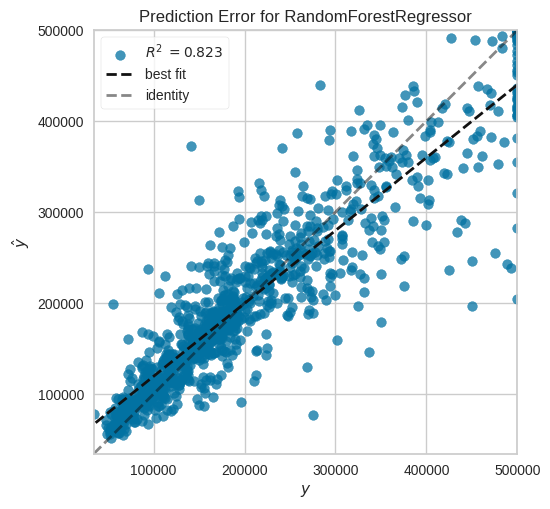

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [37]:
visualizer = PredictionError(model)
visualizer.score(X_cal, y_cal)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [38]:
# calculate calibraion errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [39]:
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.951

In [40]:
#calculate q_hat on the calibration set
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)
q_yhat_cal

98102.39540999998

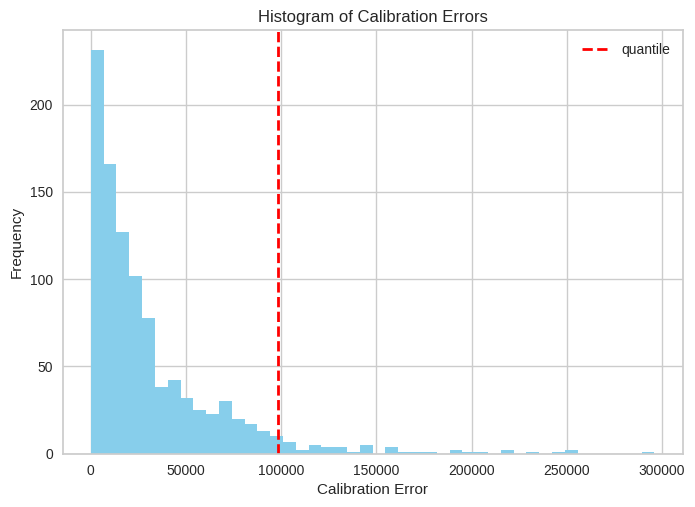

In [41]:
# Plot the histogram
plt.hist(y_cal_error, bins='auto', color='skyblue')

# Add a vertical line for the
plt.axvline(q_yhat_cal, color='red', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')

plt.show()

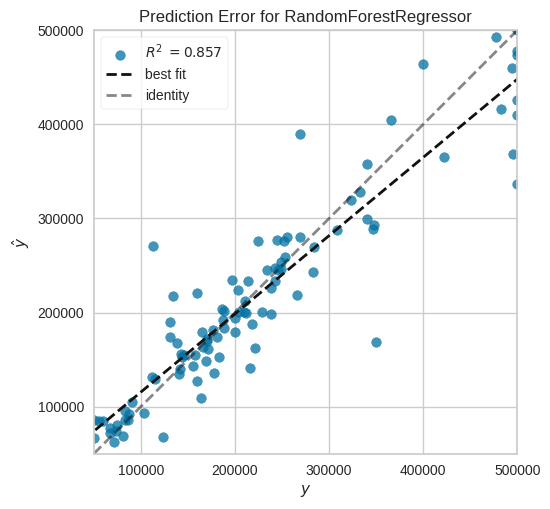

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [42]:
visualizer = PredictionError(model)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [43]:
y_hat_test_lower = y_pred_test - q_yhat_cal
y_hat_test_upper = y_pred_test + q_yhat_cal

In [44]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])
predict_df

,actual,predicted,lower_bound,upper_bound
0,245800.0,244749.02,146646.62459,342851.41541
1,137900.0,167133.00,69030.60459,265235.39541
2,218200.0,187554.00,89451.60459,285656.39541
3,220800.0,162496.00,64393.60459,260598.39541
4,170500.0,171500.00,73397.60459,269602.39541
...,...,...,...,...
95,50000.0,66740.00,-31362.39541,164842.39541
96,500001.0,409505.30,311402.90459,507607.69541
97,55000.0,84886.00,-13216.39541,182988.39541
98,204200.0,200838.00,102735.60459,298940.39541


In [45]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.95


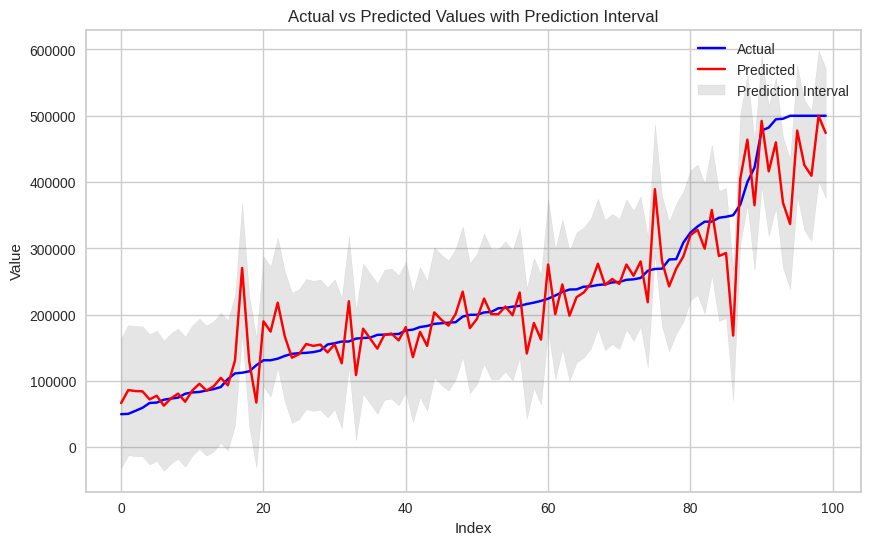

In [47]:
# Sort DataFrame by 'actual' values for smooth line plots
predict_df = predict_df.sort_values('actual').reset_index(drop=True)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(predict_df['actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(predict_df['predicted'], label='Predicted', color='red')

# Plot prediction intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Add the legend
plt.legend()

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

# Show the plot
plt.show()
